# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [313]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [315]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
 
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import f1_score

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [319]:
df = pd.read_csv('insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [322]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [324]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
438,0,36.0,36300.0,1,0
794,0,26.0,40800.0,4,0
4750,1,25.0,48700.0,2,0
3968,0,22.0,32400.0,2,0
4825,1,23.0,31500.0,0,0
4062,0,41.0,21800.0,3,0
4617,1,19.0,45400.0,0,0
3616,0,26.0,52000.0,0,0
2661,1,21.0,29400.0,2,0
1292,0,23.0,48000.0,1,0


In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [326]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [328]:
print(df[df.duplicated()])

      gender   age   income  family_members  insurance_benefits
281        1  39.0  48100.0               1                   0
488        1  24.0  32900.0               1                   0
513        0  31.0  37400.0               2                   0
718        1  22.0  32600.0               1                   0
785        0  20.0  35800.0               0                   0
...      ...   ...      ...             ...                 ...
4793       1  24.0  37800.0               0                   0
4902       1  35.0  38700.0               1                   0
4935       1  19.0  32700.0               0                   0
4945       1  21.0  45800.0               0                   0
4965       0  22.0  40100.0               1                   0

[153 rows x 5 columns]


In [329]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Genero: Muestra una media de aproximadamente 0.5 lo que indica que hay un balance entre hombres y mujeres. El valor mínimo es 0 y el máximo es 1 lo que es entendible si se ocupan 0 y 1 para distinguir entre género.

Age: Tiene rangos de edades entre 18 y 65 parecen años normales para una aseguradora, la media también parece entendible junto con la desviación estándar por lo que no se encuentran valores anormales

Inocme: Tampoco se observan valores atípicos, sólo se observa que se que cubre una amplia diversidad de ingresos.

Family members: va entre 0 y 6 familiares lo que parece común, no llega a ser exagerado y no tiene valores inesperados. Al parecer la media son entre 1 y 2 miembros.

Insurance benefits: la media es baja lo que nos dice que hay muy poca gente que recibe este beneficio, la mayoría tiene 0 prestaciones. Sin embargo, no parece algo fuera de lo común.

**Conclusión**

* No se encontraron datos sospechosos ni anormales en este tipo de datos por lo que se puede continuar a los siguientes pasos.
* Se encontraron 153 datos duplicados pero igualmente parece aceptable este número de coincidencias teniendo 5000 datos

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

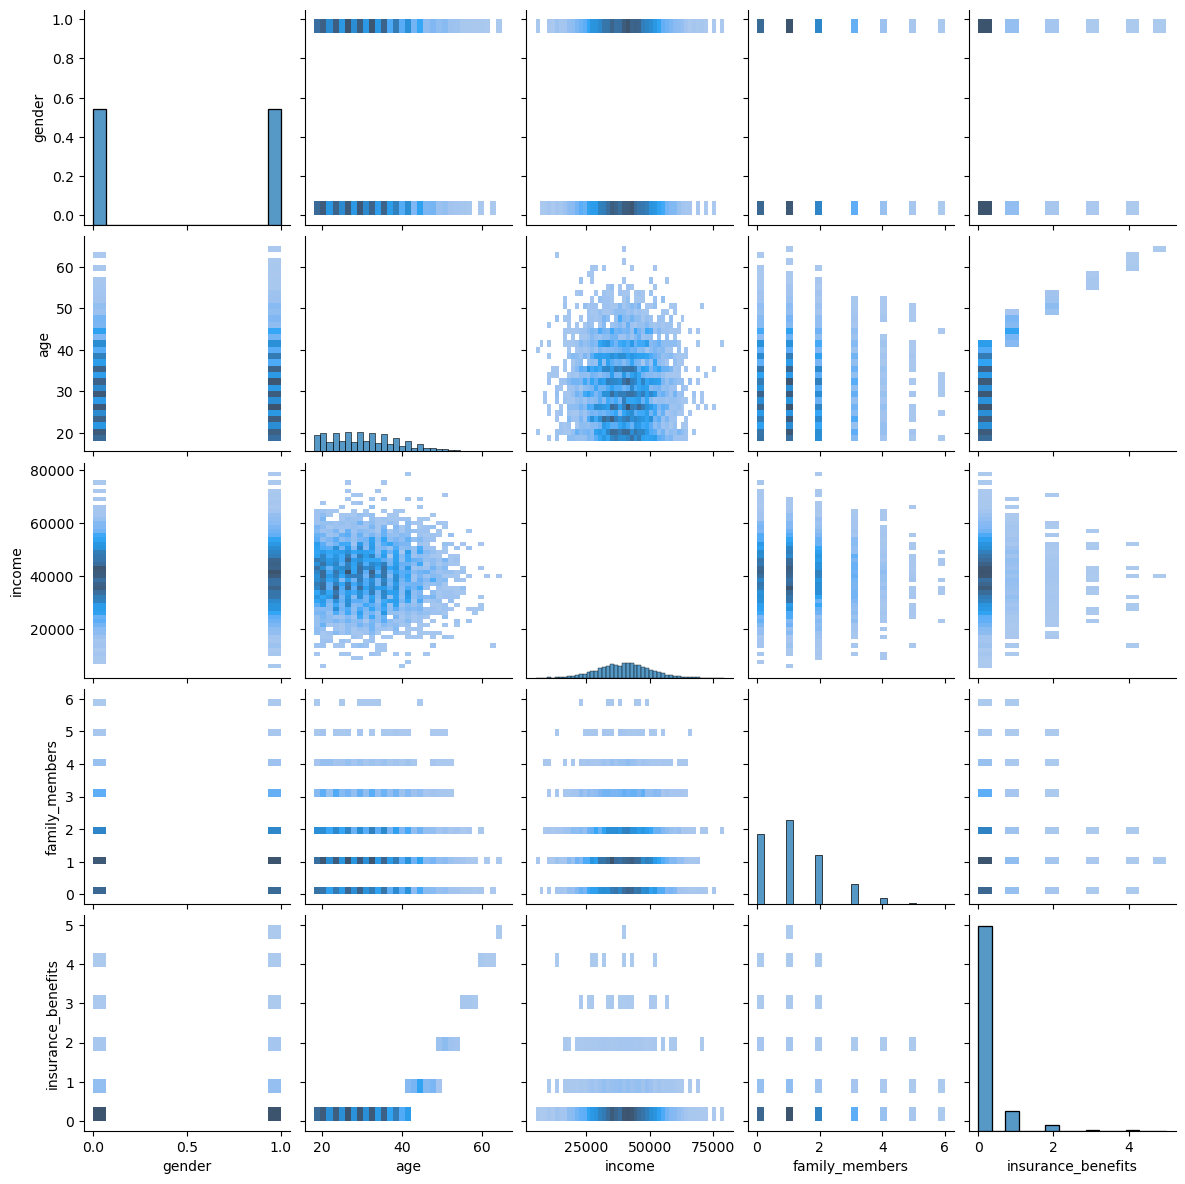

In [338]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [343]:
feature_names = ['gender', 'age', 'income', 'family_members']
print(df[feature_names].values)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


In [344]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs =  NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names].values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [349]:
# Elegimos las columnas a escalar
feature_names = ['gender', 'age', 'income', 'family_members']
# Por futuros errores cambiamos el tipo de dato de la columna 'family_members'
df['family_members'] = df['family_members'].astype(float)

# Escalamos los datos
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [351]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1019,1,0.646154,0.501266,0.333333,0
27,1,0.461538,0.440506,0.166667,0
965,1,0.430769,0.316456,0.500000,0
1361,0,0.630769,0.427848,0.000000,0
3232,0,0.630769,0.305063,0.833333,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [354]:
# Cliente específico (por ejemplo, índice 0)
n = 0
k = 5  # Número de vecinos más cercanos a obtener

# 1. Sin escalado, distancia Euclidiana
print("Sin escalado, distancia Euclidiana")
result_1 = get_knn(df, n=n, k=k, metric='euclidean')
display(result_1)
display(result_1.describe())

# 2. Sin escalado, distancia Manhattan
print("\nSin escalado, distancia Manhattan")
result_2 = get_knn(df, n=n, k=k, metric='manhattan')
display(result_2)
display(result_2.describe())

# 3. Con escalado (MaxAbsScaler), distancia Euclidiana
print("\nCon escalado, distancia Euclidiana")
result_3 = get_knn(df_scaled, n=n, k=k, metric='euclidean')
display(result_3)
display(result_3.describe())

# 4. Con escalado (MaxAbsScaler), distancia Manhattan
print("\nCon escalado, distancia Manhattan")
result_4 = get_knn(df_scaled, n=n, k=k, metric='manhattan')
display(result_4)
display(result_4.describe())

Sin escalado, distancia Euclidiana


,gender,age,income,family_members,insurance_benefits,distance
0,1,41.0,49600.0,1.0,0,0.000000
2022,1,41.0,49600.0,0.0,0,1.000000
1225,0,42.0,49600.0,0.0,1,1.732051
4031,1,44.0,49600.0,2.0,1,3.162278
3424,0,38.0,49600.0,0.0,0,3.316625


,gender,age,income,family_members,insurance_benefits,distance
count,5.000000,5.000000,5.0,5.000000,5.000000,5.000000
mean,0.600000,41.200000,49600.0,0.600000,0.400000,1.842191
std,0.547723,2.167948,0.0,0.894427,0.547723,1.417010
min,0.000000,38.000000,49600.0,0.000000,0.000000,0.000000
25%,0.000000,41.000000,49600.0,0.000000,0.000000,1.000000
50%,1.000000,41.000000,49600.0,0.000000,0.000000,1.732051
75%,1.000000,42.000000,49600.0,1.000000,1.000000,3.162278
max,1.000000,44.000000,49600.0,2.000000,1.000000,3.316625



Sin escalado, distancia Manhattan


,gender,age,income,family_members,insurance_benefits,distance
0,1,41.0,49600.0,1.0,0,0.0
2022,1,41.0,49600.0,0.0,0,1.0
1225,0,42.0,49600.0,0.0,1,3.0
4031,1,44.0,49600.0,2.0,1,4.0
815,1,37.0,49600.0,2.0,0,5.0


,gender,age,income,family_members,insurance_benefits,distance
count,5.000000,5.00000,5.0,5.0,5.000000,5.000000
mean,0.800000,41.00000,49600.0,1.0,0.400000,2.600000
std,0.447214,2.54951,0.0,1.0,0.547723,2.073644
min,0.000000,37.00000,49600.0,0.0,0.000000,0.000000
25%,1.000000,41.00000,49600.0,0.0,0.000000,1.000000
50%,1.000000,41.00000,49600.0,1.0,0.000000,3.000000
75%,1.000000,42.00000,49600.0,2.0,1.000000,4.000000
max,1.000000,44.00000,49600.0,2.0,1.000000,5.000000



Con escalado, distancia Euclidiana


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.017754
4869,1,0.646154,0.637975,0.166667,1,0.018418
3275,1,0.646154,0.651899,0.166667,1,0.028550


,gender,age,income,family_members,insurance_benefits,distance
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1.0,0.633846,0.637722,0.166667,0.400000,0.014210
std,0.0,0.012872,0.008834,0.000000,0.547723,0.011180
min,1.0,0.615385,0.627848,0.166667,0.000000,0.000000
25%,1.0,0.630769,0.634177,0.166667,0.000000,0.006329
50%,1.0,0.630769,0.636709,0.166667,0.000000,0.017754
75%,1.0,0.646154,0.637975,0.166667,1.000000,0.018418
max,1.0,0.646154,0.651899,0.166667,1.000000,0.028550



Con escalado, distancia Manhattan


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.024245
4869,1,0.646154,0.637975,0.166667,1,0.025511
2103,1,0.630769,0.596203,0.166667,0,0.031646


,gender,age,income,family_members,insurance_benefits,distance
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1.0,0.630769,0.626582,0.166667,0.200000,0.017546
std,0.0,0.010879,0.017425,0.000000,0.447214,0.013609
min,1.0,0.615385,0.596203,0.166667,0.000000,0.000000
25%,1.0,0.630769,0.627848,0.166667,0.000000,0.006329
50%,1.0,0.630769,0.634177,0.166667,0.000000,0.024245
75%,1.0,0.630769,0.636709,0.166667,0.000000,0.025511
max,1.0,0.646154,0.637975,0.166667,1.000000,0.031646


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Sí afecta el escalado en todas las métricas de las distancias (excepto en el mínimo). Al escalar los datos los valores de las distancias se vuelven más pequeños, esto tiene sentido ya que el escalado que estamos aplicando reduce el valor de los datos originales en buena medida.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Son menos similares comparándolos con la distancia euclidiana, tanto su varianza como su promedio son mayores

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [362]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)
display(df)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41.0,49600.0,1.0,0,0
1,0,46.0,38000.0,1.0,1,1
2,0,29.0,21000.0,0.0,0,0
3,0,21.0,41700.0,2.0,0,0
4,1,28.0,26100.0,0.0,0,0
...,...,...,...,...,...,...
4995,0,28.0,35700.0,2.0,0,0
4996,0,34.0,52400.0,1.0,0,0
4997,0,20.0,33900.0,2.0,0,0
4998,1,22.0,32700.0,3.0,0,0


In [364]:
# comprueba el desequilibrio de clases con value_counts()

print(df['insurance_benefits_received'].value_counts())

# Si se necesita verlo en porcetaje
print('\nEn porcentaje:')
print((df['insurance_benefits_received'].value_counts())/(len(df))*100)

insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64

En porcentaje:
insurance_benefits_received
0    88.72
1    11.28
Name: count, dtype: float64


In [366]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print(cm)

In [368]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [370]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [372]:
def knn(X_train, X_test, y_train, y_test, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    prediction = neigh.predict(X_test)
    score = f1_score(y_test, prediction)
    return score

In [374]:
## Dividimos los datos
# Datos sin escalar
X = df[feature_names].values
y = df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
# Datos escalados
X_scl = df_scaled[feature_names].values
y_scl = y
X_train_scl, X_test_scl, y_train_scl, y_test_scl = train_test_split(X_scl, y_scl, test_size=0.3, random_state=12345)

In [376]:
k_cls = 10
f1_scores_raw = []
f1_scores_scl = []
for i in range(1, k_cls+1):
    
    scores1 = knn(X_train, X_test, y_train, y_test, i)
    scores2 = knn(X_train_scl, X_test_scl, y_train_scl, y_test_scl, i)
    
    f1_scores_raw.append(scores1)
    f1_scores_scl.append(scores2)

print('Puntuación F1 para datos sin escalar:')
display(f1_scores_raw)
print('Puntuación F1 para datos escaladps:')
display(f1_scores_scl)

Puntuación F1 para datos sin escalar:


[0.60431654676259,
 0.4056603773584906,
 0.4052863436123348,
 0.27835051546391754,
 0.271356783919598,
 0.11428571428571428,
 0.11299435028248588,
 0.07100591715976332,
 0.08235294117647059,
 0.0]

Puntuación F1 para datos escaladps:


[0.9659442724458205,
 0.9281045751633987,
 0.9493670886075949,
 0.9078947368421053,
 0.9240506329113924,
 0.9036544850498339,
 0.9201277955271565,
 0.9013157894736842,
 0.9155844155844156,
 0.8791946308724832]

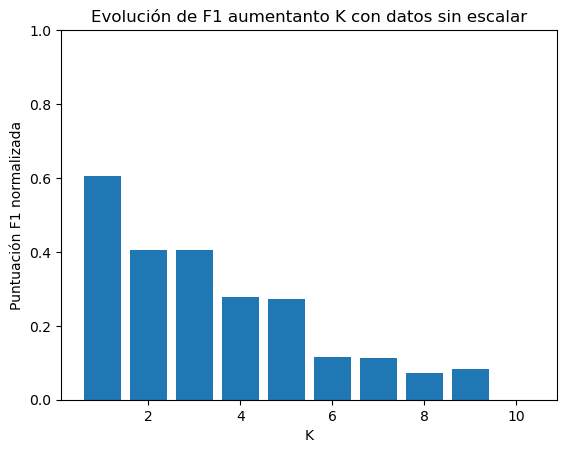

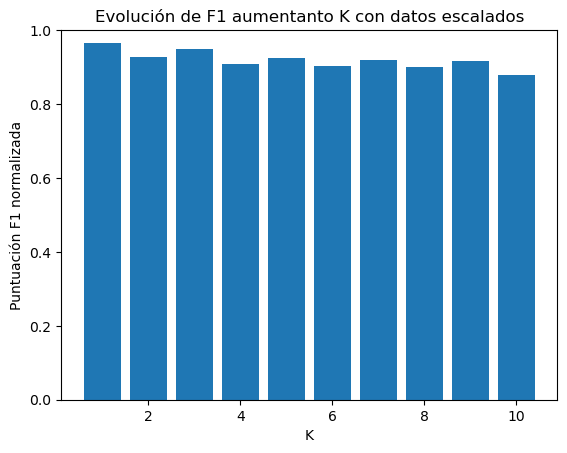

In [377]:
K = range(1,11)
plt.bar(K,f1_scores_raw)
plt.title('Evolución de F1 aumentanto K con datos sin escalar')
plt.xlabel('K')
plt.ylabel('Puntuación F1 normalizada')
plt.ylim(0,1)
plt.show()

plt.bar(K,f1_scores_scl)
plt.title('Evolución de F1 aumentanto K con datos escalados')
plt.xlabel('K')
plt.ylabel('Puntuación F1 normalizada')
plt.ylim(0,1)
plt.show()

**Observaciones**

1. Podemos observar que el escalado influye en buena medida con la ayuda de la buena clasificación y desempeño del algortimo KNN
2. El algoritmo KNN presentó un mejor resultados que el algotimo dummy
3. Variando el número de vecinos cercanos llegamos a la conclusión que desde el primer vecino, ya existe una buena clasificación para estos datos.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [385]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y
        
    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [387]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [389]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [391]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

lr = MyLinearRegression()

lr.fit(X_train_scl, y_train_scl)
print(lr.weights)

y_test_pred = lr.predict(X_test_scl)
eval_regressor(y_test_scl, y_test_pred)

[-6.50583302e-01 -7.31018901e-04  1.60816093e+00  1.08173008e-02
 -3.79749246e-02]
RMSE: 0.23
R2: 0.66


**Observaciones**

1. Se observa que para la regresión lineal los datos escalados presentan un menor error RMSE
2. Este proceso de escalados también afecta en los valores de los pesos de la regresión claramente.
3. R2 se mantiene con el mismo valor.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [396]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [398]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [401]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [404]:
det = np.linalg.det(P)
print(det)

0.24339135998015468


Como el determinante de la matriz P es diferente de 0, la matriz P es invertible.

Otra forma es comprobando que <td>$A^{-1}A = AA^{-1} = I$:


In [407]:
I = np.linalg.inv(P.T @ P) @ P.T @ P
print(I)

[[ 1.00000000e+00 -2.22044605e-16  4.44089210e-16 -7.77156117e-16]
 [-1.11022302e-16  1.00000000e+00  2.22044605e-16  2.77555756e-16]
 [-1.77635684e-15 -1.11022302e-15  1.00000000e+00 -2.44249065e-15]
 [ 3.60822483e-16 -8.46545056e-16  2.84494650e-16  1.00000000e+00]]


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

Sí, se debe volver a multiplar la matriz resultante de la tranformación por la matriz P inversa

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

$$
X' = X \times P
$$
$$
X'\times P^{-1} = X 
$$

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [414]:
print(X[0:3])
X2 = X @ P
print(X2[0:3])
X1 = X2 @ np.linalg.inv(P)
print(X1[0:3])

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]]
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-3.18323146e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [ 1.36424205e-12  2.90000000e+01  2.10000000e+04  0.00000000e+00]]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Una razón es que la computadora esta trabajando con punto flotante de 64 bits, eso hace que exprese el 0 de una forma muy pequeña 

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

La transformación de los datos mediante una matriz invertible 𝑃 no afecta los valores predichos ni la calidad de la regresión lineal. Esto asegura que la ofuscación de datos es segura en términos de preservar la calidad del modelo.

**Prueba analítica**

Regresión lineal con datos ofuscados:
$$
w_P = [(XP)^T XP]^{-1} (XP)^T y
$$
Expandiendo:
$$
(XP)^T XP = P^T X^T XP
$$
Entonces:
$$
w_P = [P^T X^T XP]^{-1} (P^T X^T) y
$$
RELACIÓN ENTRE w y wp:
    -Usando la propiedad de inversión de matrices:
$$
[P^T X^T XP]^{-1} = P^{-1}(X^T X)
$$
Sustituyendo en la fórmula de wp:
$$
w_P = P^{-1}(X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$
Por propiedad de identidad multiplicativa:
$$
w_P = P^{-1}(X^T X)^{-1} X^T y
$$
Dado que $$ w = (X^T X)^{-1} X^T y, tenemos: $$
$$
w_P = P^{-1}w
$$

VALORES PREDICHOS CON wp:
$$
y_P = (XP)w_P
$$
Sustituyendo wp:
$$
y_P = (XP)(P^{-1}w)
$$
Por propiedad de identidad multiplicativa:
$$
y_P = Xw
$$
Esto demuestra que:
$$
y_P = y
$$
Dado que yp = y, los valores predichos no cambian, y por lo tanto:
$$
RECM_P = RECM
$$

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- Fue invertible al segundo intento
- Utiliza $XP$ como la nueva matriz de características

In [428]:
np.random.seed(0)
P = np.random.rand(4,4)
print(P)
det = np.linalg.det(P)
print(det)

[[0.5488135  0.71518937 0.60276338 0.54488318]
 [0.4236548  0.64589411 0.43758721 0.891773  ]
 [0.96366276 0.38344152 0.79172504 0.52889492]
 [0.56804456 0.92559664 0.07103606 0.0871293 ]]
0.13938851462425653


In [430]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y
        
    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [432]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')   

In [434]:
X_ofus = X @ P

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
X_train_ofus, X_test_ofus, y_train_ofus, y_test_ofus = train_test_split(X_ofus, y, test_size=0.3, random_state=12345)

lin_r = MyLinearRegression()

# Regresión con datos sin ofuscar
lin_r.fit(X_train, y_train)
print(lin_r.weights)

y_test_pred = lin_r.predict(X_test)
eval_regressor(y_test, y_test_pred)

# Regresión con datos ofuscados
lin_r.fit(X_train_ofus, y_train_ofus)
print(lin_r.weights)

y_test_pred_ofus = lin_r.predict(X_test_ofus)
eval_regressor(y_test_ofus, y_test_pred_ofus)


[-9.43539012e-01  1.64272726e-02  3.57495491e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66
[-0.94353848 -0.03865472  0.00560961  0.01189941  0.04854999]
RMSE: 0.34
R2: 0.66


Conclusión:

Los valores de peso cambiaron, lo que era de esperarse pero los errores mantuvieron su valor lo que demuestra que la técnica de ofuscación mantiene la calidad del modelo 

# Conclusiones

1. Se presentaron dato sin problemas aparentes
2. El análisis exploratarió no mostro relaciones concluyentes
3. En estos datos la distancia Euclediana mostro mejores resultados que la distania manhatan
4. El escalado de los datos mostró una mejora significativa tanto en los algoritmos KNN al encontrar las distancias y al clasificar como el de regresión lineal
5. En los primeros vecinos cercanos se lográ una buena clasificación y con datos escalados
6. Se demostró que la técnica de ofuscación preserva la calidad de los modelos afectando sólo a los valores de pesos
7. Se implemetó correctamente nuestro propio algoritmo de regresión lineal
8. Se aprendieron Propiedades de las matrices

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>